## Packages

In [25]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

In [26]:
 # Ensure project root (with src/) is on sys.path so imports like `from src...` work in notebooks
import sys
from pathlib import Path
p = Path.cwd()
for _ in range(6):
    if (p / 'pyproject.toml').exists():
        project_root = p
        break
    if p.parent == p:
        project_root = Path.cwd()
        break
    p = p.parent
else:
    project_root = Path.cwd()
# Insert at front so local src/ takes precedence
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))
print(f'Added project root to sys.path: {project_root}')

Added project root to sys.path: c:\Users\Nico\Documents\Projects\stock-predictor


## Input Parameters

In [27]:
ticker = "^GSPC"
start_date = "2019-01-01"
rsi_period = 14
periods = [20, 50, 200]
start_plot_date = "2024-01-01"
df = yf.download(ticker, start=start_date, interval="1d")
close_df = df[['Close']].copy()

C:\Users\Nico\AppData\Local\Temp\ipykernel_21644\3370180086.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date, interval="1d")
[*********************100%***********************]  1 of 1 completed


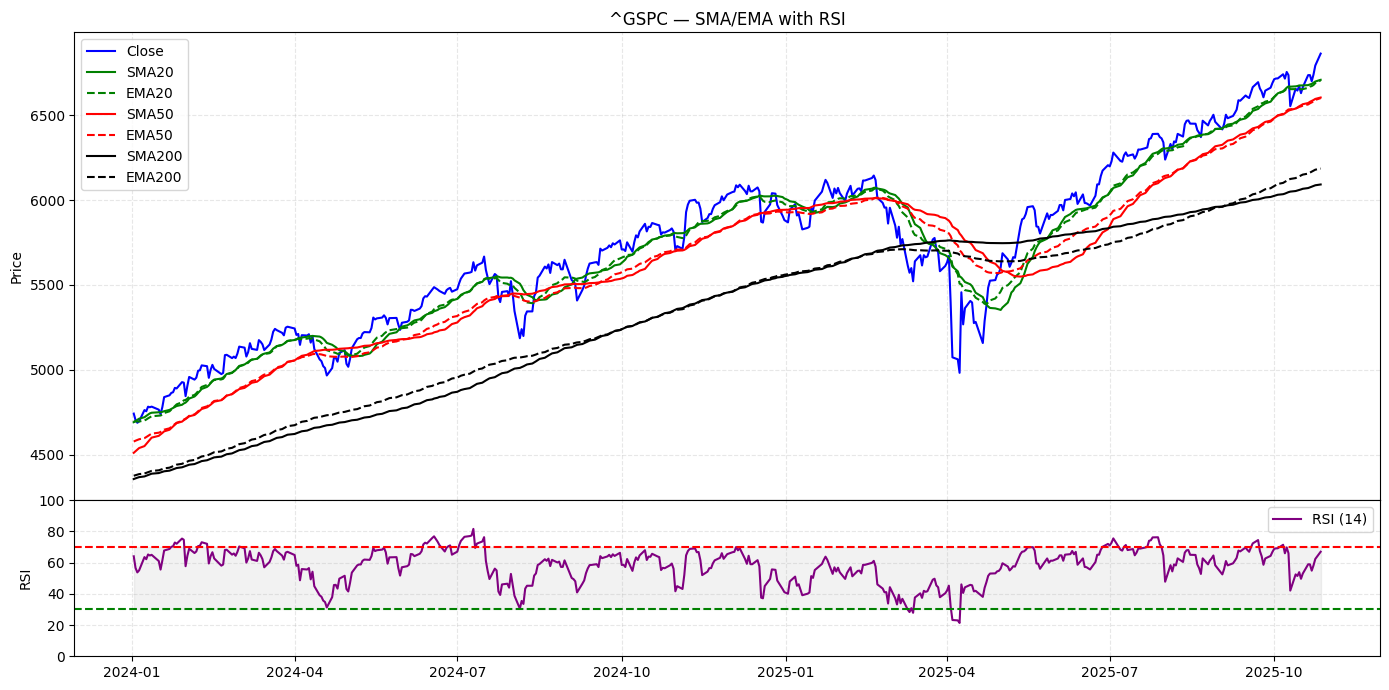

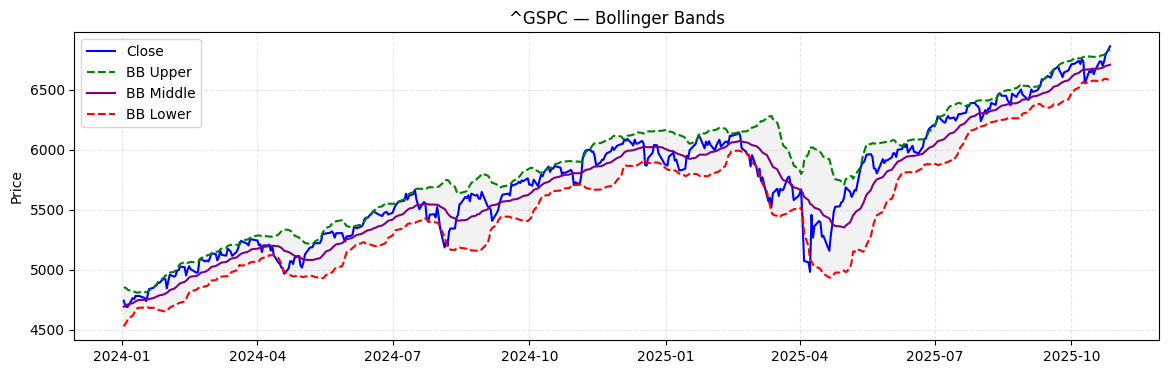

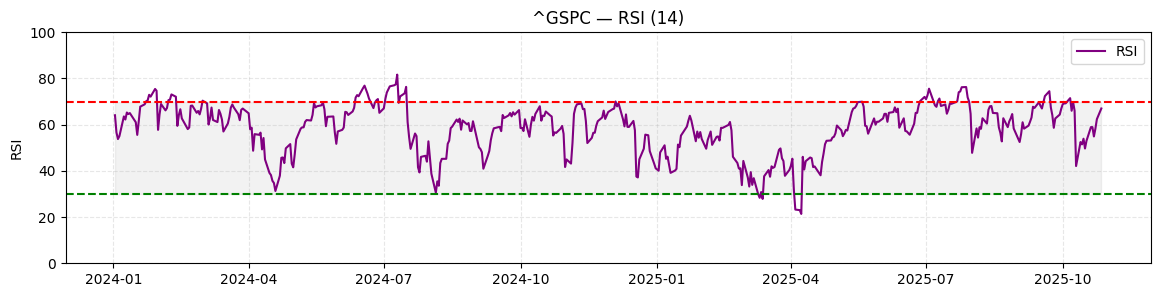

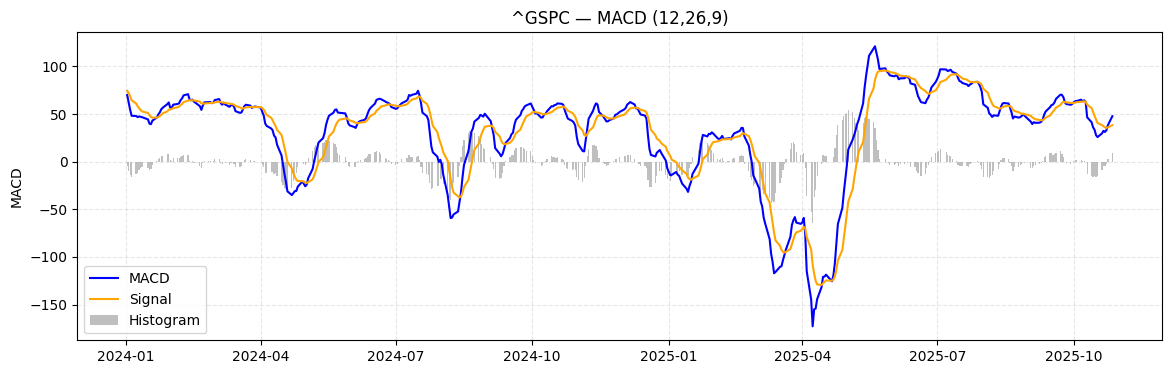

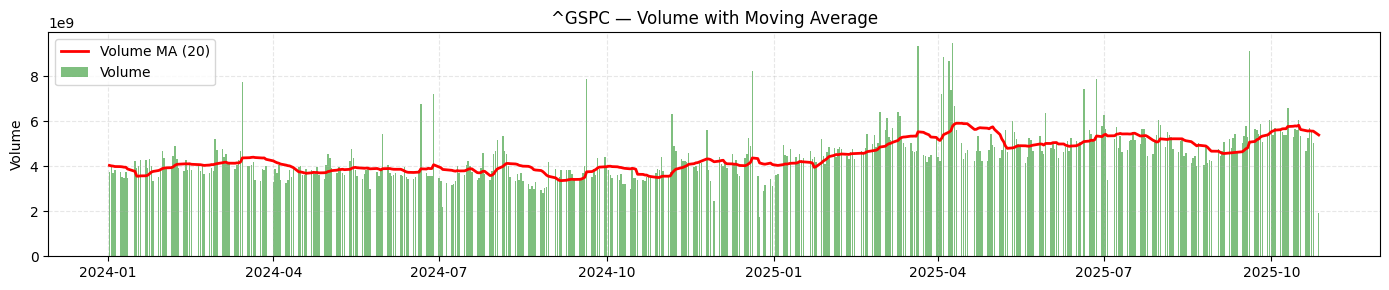

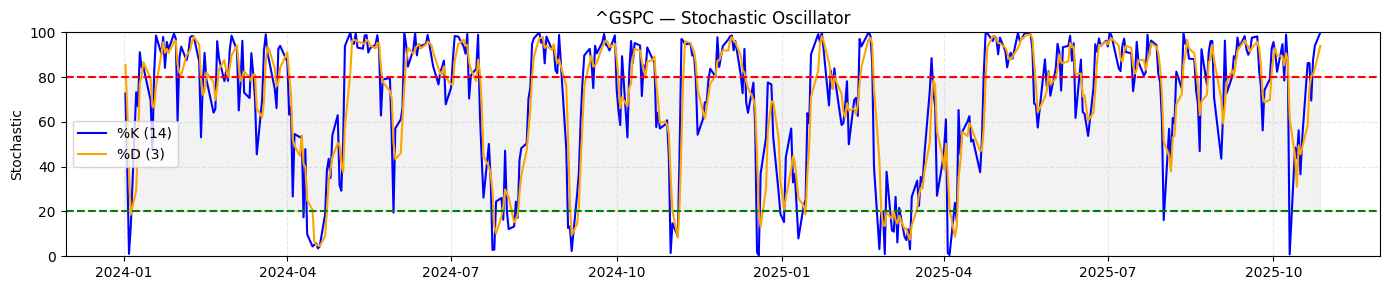

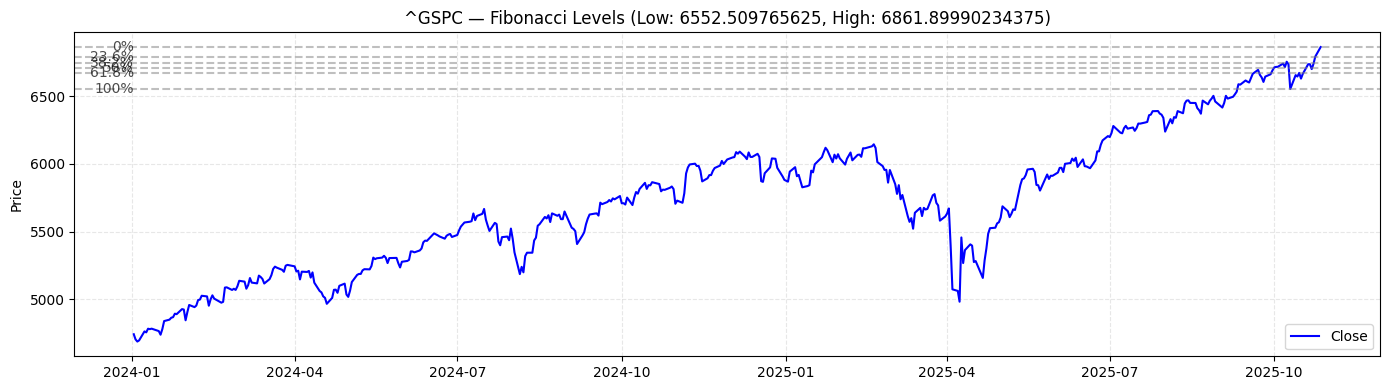

In [28]:
from src.calc_indicators import calc_sma_ema, calc_rsi, calc_macd
from src.plot_indicators import plot_sma_ema_with_rsi, plot_bollinger_bands, plot_rsi, plot_macd, plot_full_chart, plot_volume, plot_stochastic, plot_fibonacci_levels

plot_sma_ema_with_rsi(df, ticker, start_plot_date=start_plot_date)
plot_bollinger_bands(df, ticker, start_plot_date=start_plot_date)
plot_rsi(df, ticker, start_plot_date=start_plot_date)
plot_macd(df, ticker, start_plot_date=start_plot_date)

plot_volume(df, ticker, start_plot_date=start_plot_date)
plot_stochastic(df, ticker, start_plot_date=start_plot_date)
plot_fibonacci_levels(df, ticker, start_plot_date=start_plot_date, auto_detect=True, lookback_period=30)


## SMA, EMA, BB printing

In [29]:
from src.technische_indicatoren import technische_indicatoren
technische_indicatoren(close_df, periods)

Laatste waarden voor alle indicatoren (datum: 2025-10-27):
- SMA20: 6707.60
- EMA20: 6704.59
- SMA50: 6603.40
- EMA50: 6599.87
- SMA200: 6091.51
- EMA200: 6185.30
- BB_Upper: 6835.91
- BB_Middle: 6707.60
- BB_Lower: 6579.30


## Summary output Technical analysis

In [30]:
from src.summary_analysis import summary_technical_indicators
summary_technical_indicators(ticker, df, rsi_period, periods, start_plot_date);

Analyse voor **^GSPC** (laatste datum: 2025-10-27):
- RSI (14): 67.02 → **Neutraal**
- Bollinger Bands: **Boven bovenste band (mogelijk overbought, bearish)**
- MACD (12,26,9): **Bullish (MACD boven signaallijn, koopsignaal)**
- SMA/EMA (20, 50, 200): **Sterk bullish (koers boven alle SMA/EMA)**



c:\Users\Nico\Documents\Projects\stock-predictor\src\plot_indicators.py:190: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


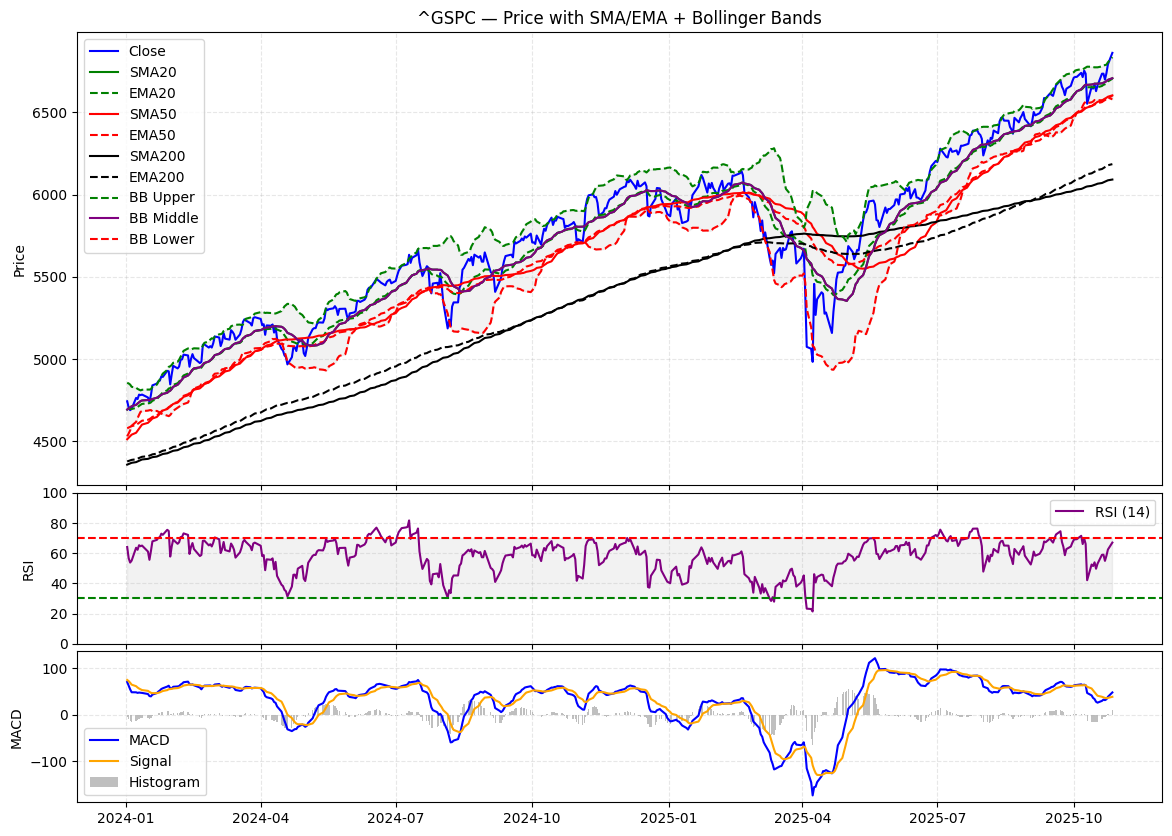

Plotted ^GSPC with indicators: SMA: [20, 50, 200], EMA: [20, 50, 200], Bollinger Bands: period=20, std=2, RSI: period=14, MACD: fast=12, slow=26, signal=9


In [31]:
plot_full_chart(df, ticker, [20, 50, 200], start_plot_date, sma=True, ema=True);

# Fugro:
- Sell order: EMA50, RSI +- 60. Houd MACD in de gaten, moet bullish niveau blijven aangeven

## RSI predictor plot

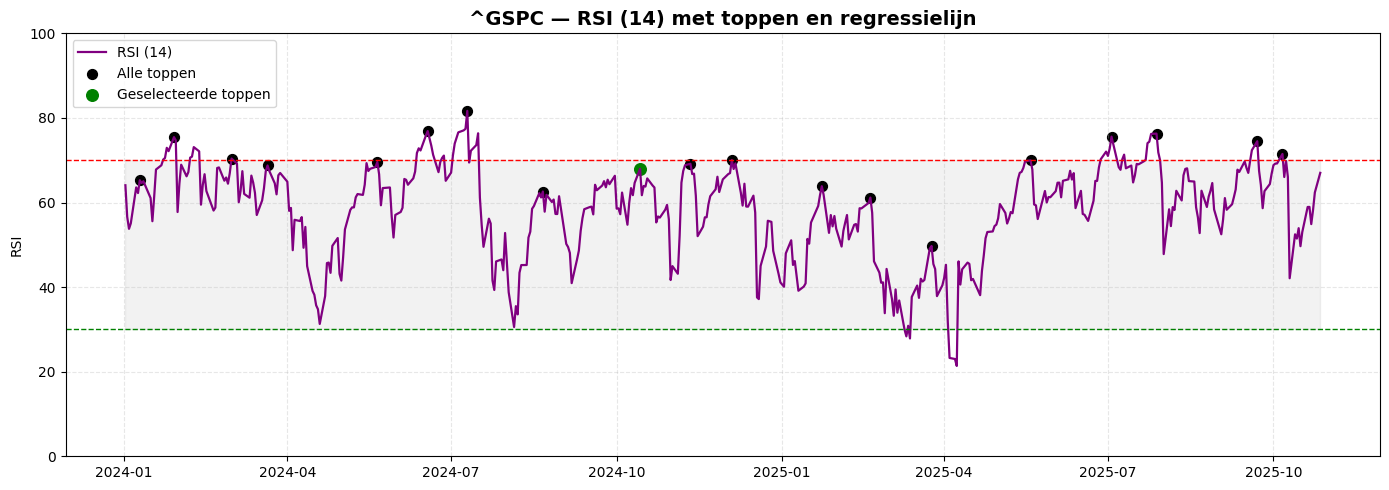

In [32]:
from src.RSI_predictor import plot_rsi_peaks
plot_rsi_peaks(df, rsi_period, start_plot_date, ticker, 
                                   dof=1, future_days=65, selected_peak_indices= [8])

## Rebound or trendswitch

In [33]:
from src.tryout import assess_trend
df_rebound_test = df
if isinstance(df_rebound_test.columns, pd.MultiIndex):
    df_rebound_test.columns = [col[0] for col in df_rebound_test.columns]

assess_trend(df_rebound_test, start_plot_date, rsi_period=rsi_period, periods=periods, plot=False)

'Uncertain or Continuing Trend'

In [34]:
def plot_mm_rsi_ema(df, ticker, start_plot_date, ema_periods=[20, 50], rsi_period=14, mfi_period=14):
    data = df.copy()
    data = data.loc[data.index >= start_plot_date]

    # === EMA berekenen ===
    for p in ema_periods:
        data[f'EMA_{p}'] = data['Close'].ewm(span=p, adjust=False).mean()

    # === RSI berekenen ===
    delta = data['Close'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=rsi_period).mean()
    avg_loss = loss.rolling(window=rsi_period).mean()
    rs = avg_gain / avg_loss.replace(0, 0.0001)
    data['RSI'] = 100 - (100 / (1 + rs))

    # === MFI berekenen ===
    typical_price = (data['High'] + data['Low'] + data['Close']) / 3
    money_flow = typical_price * data['Volume']
    flow_direction = (data['Close'].diff() > 0).astype(int) - (data['Close'].diff() < 0).astype(int)
    raw_money_flow = money_flow * flow_direction
    positive_flow = raw_money_flow.where(raw_money_flow > 0, 0).rolling(window=mfi_period).sum()
    negative_flow = -raw_money_flow.where(raw_money_flow < 0, 0).rolling(window=mfi_period).sum()
    mfi = 100 - (100 / (1 + positive_flow / negative_flow.replace(0, 0.0001)))
    data['MFI'] = mfi

    # === Plot instellen ===
    fig, (ax_price, ax_rsi, ax_mfi) = plt.subplots(3, 1, figsize=(12, 10), sharex=True,
                                                  gridspec_kw={'height_ratios': [3, 1, 1]})
    fig.suptitle(f"{ticker} — MM-RSI-EMA", fontsize=14, fontweight="bold")

    # --- Prijs + EMA ---
    ax_price.plot(data.index, data['Close'], label='Close', color='black', linewidth=1)
    for p in ema_periods:
        ax_price.plot(data.index, data[f'EMA_{p}'], label=f'EMA {p}', color='blue' if p == 20 else 'red')
    ax_price.set_ylabel("Prijs")
    ax_price.legend(loc="upper left")
    ax_price.grid(True, linestyle="--", alpha=0.3)

    # --- RSI ---
    ax_rsi.plot(data.index, data['RSI'], label=f'RSI {rsi_period}', color='purple')
    ax_rsi.axhline(70, color='red', linestyle='--', linewidth=1)
    ax_rsi.axhline(30, color='green', linestyle='--', linewidth=1)
    ax_rsi.fill_between(data.index, 70, 100, where=(data['RSI'] > 70), color='red', alpha=0.1)
    ax_rsi.fill_between(data.index, 0, 30, where=(data['RSI'] < 30), color='green', alpha=0.1)
    ax_rsi.set_ylabel("RSI")
    ax_rsi.set_ylim(0, 100)
    ax_rsi.legend(loc="upper left")
    ax_rsi.grid(True, linestyle="--", alpha=0.3)

    # --- MFI ---
    ax_mfi.bar(data.index, data['MFI'], color=['green' if x < 20 else 'red' if x > 80 else 'yellow' for x in data['MFI']])
    ax_mfi.axhline(80, color='red', linestyle='--', linewidth=1)
    ax_mfi.axhline(20, color='green', linestyle='--', linewidth=1)
    ax_mfi.set_ylabel("MFI")
    ax_mfi.set_ylim(0, 100)
    ax_mfi.grid(True, linestyle="--", alpha=0.3)

    plt.tight_layout()
    plt.show()


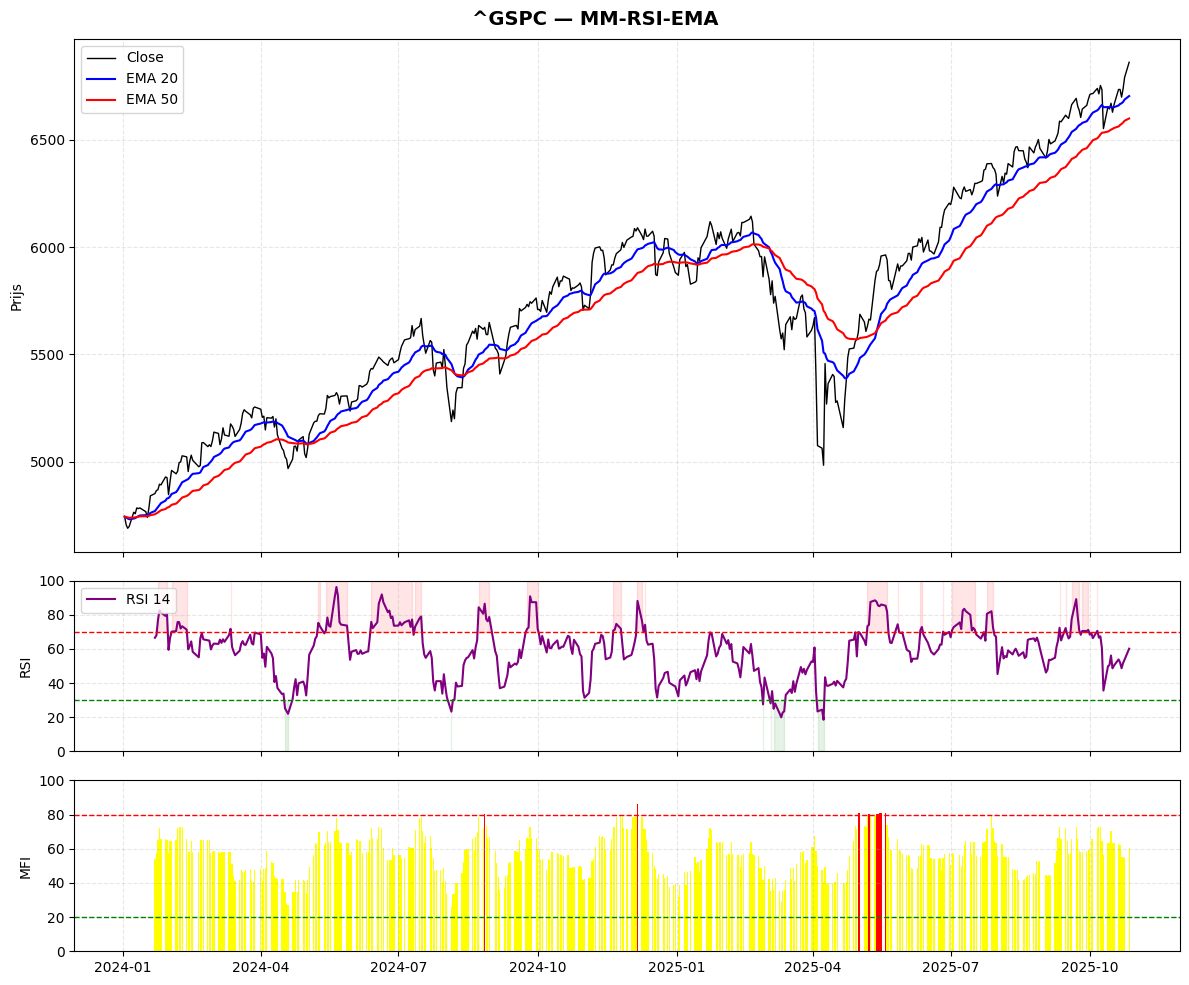

In [35]:
plot_mm_rsi_ema(df, ticker, start_plot_date)